<font size="+2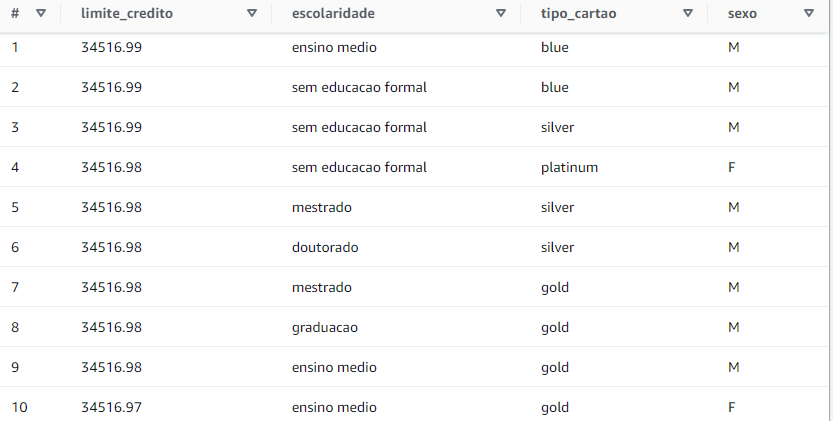">**Exploração e análise de dados de crédito com SQL e Python**</font>



In [ ]:
import pandas as pd

In [ ]:
#Faremos a importação dos dados de entregas no formato csv
!wget -q -O credito_original.csv https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/credito.csv

In [ ]:
#Será aberto o arquivo csv para começar a trabalhar com os dados
with open(file='./credito_original.csv',mode='r',encoding='utf8') as arquivo:
  dados = pd.read_csv(arquivo)

In [ ]:
#Analisando a estrutura dos dados e quais colunas serão importante para os insights
dados.head()

In [ ]:
dados[['limite_credito','valor_transacoes_12m']] = dados[['limite_credito','valor_transacoes_12m']].apply(lambda x: x.str.replace('.','',regex=True))

In [ ]:
dados.head()

In [ ]:
dados[['limite_credito','valor_transacoes_12m']] = dados[['limite_credito','valor_transacoes_12m']].replace(',','.',regex=True)

In [ ]:
#Separando apenas as colunas que serão utilizadas na análise
dados = dados[['idade','sexo','dependentes','escolaridade','estado_civil','salario_anual','tipo_cartao','qtd_produtos','iteracoes_12m','meses_inativo_12m','limite_credito','valor_transacoes_12m','qtd_transacoes_12m']]

In [ ]:
dados.head()

In [ ]:
#Salvando o arquivo em csv após tratamento, para realizarmos análise pelo AWS Athena
dados.to_csv('./credito_tratado.csv',sep=',',index=False,header=False)

<font size="+1">**Conjunto de dados:**</font>

Os dados representam informações de clientes de um banco e contam com as seguintes colunas em sua estrutura:


*   idade = idade do cliente
*   sexo = sexo do cliente (F ou M)
*   dependentes = número de dependentes do cliente
*   escolaridade = nível de escolaridade do clientes
*   salario_anual = faixa salarial que o cliente se encontra
*   tipo_cartao = tipo de cartao que o cliente possui do banco
*   qtd_produtos = quantidade de produtos comprados nos últimos 12 meses
*   iteracoes_12m = quantidade de iterações/transacoes nos ultimos 12 meses
*   meses_inativo_12m = quantidade de meses que o cliente ficou inativo
*   limite_credito = limite de credito do cliente
*   valor_transacoes_12m = valor das transações dos ultimos 12 meses
*   qtd_transacoes_12m = quantidade de transacoes dos ultimos 12 meses

Os dados foram importados e tratados no Python e usados para criar um bucket no AWS S3 e criado a tabela no AWS Athena. O link para acesso aos dados: [Conjuntos de dados](https://github.com/andre-marcos-perez/ebac-course-utils/tree/main/dataset)

<font size="+1">**Exploração de dados:**</font>

A segunda fase da análise é entender o que tem na nossa matéria-prima. Vamos a exploração de dados:


**Precisamos conhecer qual o tamanho dos nossos dados:**

SELECT*FROM credito LIMIT 5

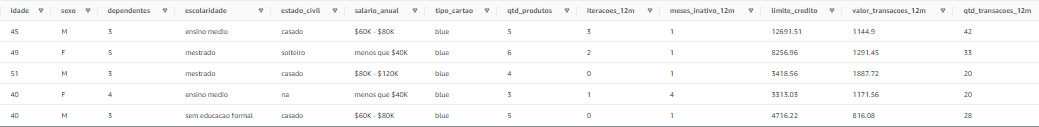



**Precisamos saber também os tipos das colunas dos nossos dados:**

DESCRIBE credito

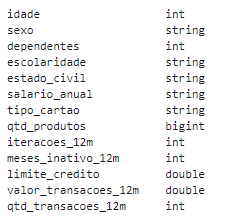

**Qual a quantidade de informações temos na nossa base de dados?**

SELECT COUNT(*) AS QUANTIDADE_DE_LINHAS from credito

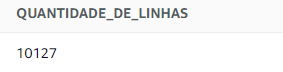


**Qual a escolaridade e a quantidade por cada categoria nesse conjunto de dados?**

SELECT escolaridade, count(escolaridade) AS QUANTITATIVO FROM credito
GROUP BY escolaridade
ORDER BY QUANTITATIVO DESC


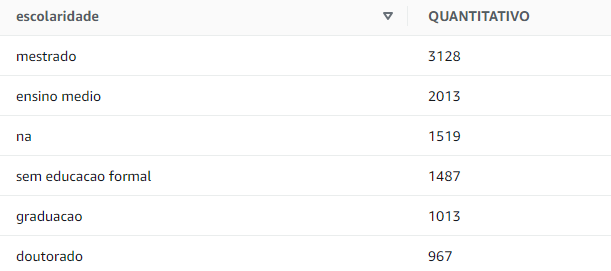


É possível reparar que existem algumas informações nulas na tabela (valor na), vamos olhar mais de perto para os valores das outras colunas!


**Qual a faixa salarial anual dos nossos clientes e a quantidade por cada categoria?**

SELECT salario_anual, COUNT(salario_anual) AS QTD_faixa_salario FROM credito
GROUP BY salario_anual
ORDER BY QTD_faixa_salario DESC

**Como está dividido nossos clientes por sexo:**

SELECT sexo, COUNT(sexo) AS QUANTIDADE_SEXO FROM credito GROUP BY sexo

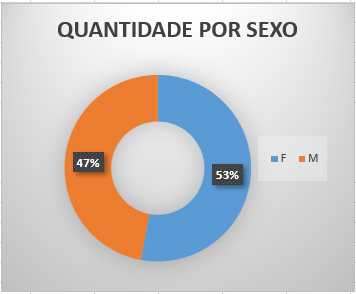

**Quais os tipos de cartões que temos no banco e a quantidade de clientes em cada tipo?**

SELECT tipo_cartao, COUNT(tipo_cartao) QUANT_TIPO FROM credito
GROUP BY tipo_cartao
ORDER BY QUANT_TIPO DESC

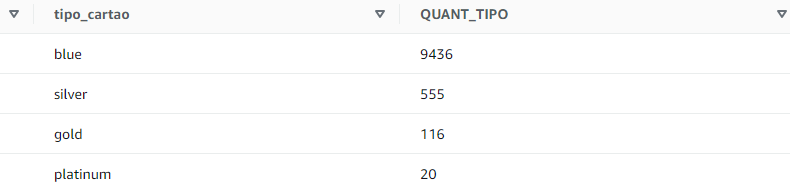



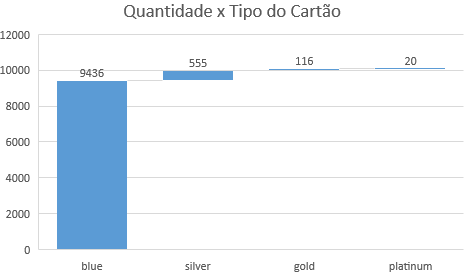


Aqui podemos ver uma dominação do tipo de cartão "blue" e vai diminuindo a medida que o tipo do cartão vai melhorando, mas ainda sim a quantidade de clientes tipo "blue" é muito maior, seria uma boa alternativa estudar a possibilidade de mudança do serviço oferecido.

**Precisamos saber qual o valor máximo, mínimo e a média de crédito dos clientes por cada tipo de cartão:**

SELECT tipo_cartao,min(limite_credito) AS MINIMO_CREDITO, max(limite_credito) AS MAXIMO_CREDITO, ROUND(AVG(limite_credito),2) AS MEDIA_CREDITO, COUNT(tipo_cartao) AS QUANT_PESSOAS FROM credito
GROUP BY tipo_cartao
ORDER BY MEDIA_CREDITO


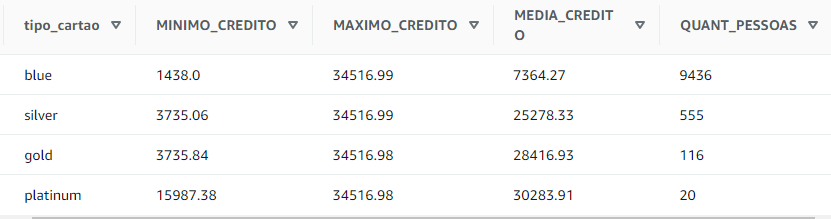


Essa informação é importante para sabermos a média de crédito por cada tipo de cartão e quais os limites, podemos ver a quantidade de pessoas que podem ter um tipo de cartão melhor

**Podemos verificar quais são os limites máximos de créditos por cada sexo e escolaridade:**


select max(limite_credito) as limite_credito, escolaridade, tipo_cartao, sexo from credito
where escolaridade != 'na' and tipo_cartao != 'na'
group by escolaridade, tipo_cartao, sexo
order by limite_credito desc
limit 10


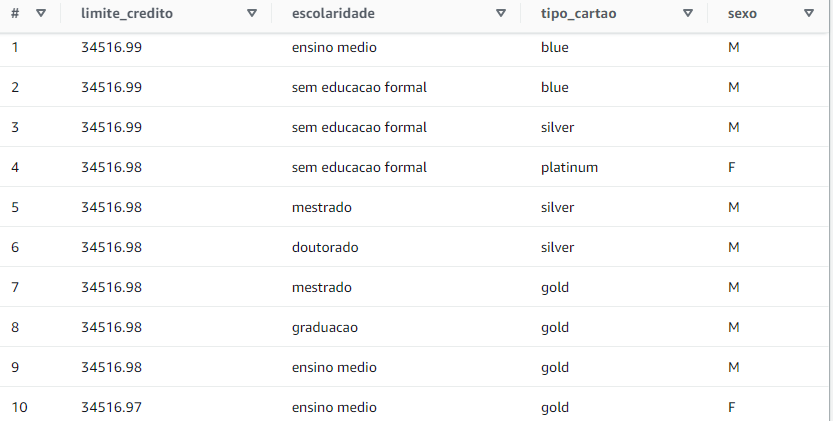


Vemos que em todas as categorias possuem o limite muito próximo, ou seja, existem pessoas que podemos oferecer um tipo de cartão melhor do que está atualmente.

**Qual a média do limite por cada faixa salarial?**

SELECT avg(qtd_produtos) as QTS_PRODUTOS, ROUND(avg(valor_transacoes_12m),2) as MEDIA_VALOR_TRANSACOES, ROUND(avg(limite_credito),2) as MEDIA_LIMITE, sexo, salario_anual
FROM credito
WHERE salario_anual != 'na'
GROUP BY sexo, salario_anual
ORDER BY avg(valor_transacoes_12m) DESC

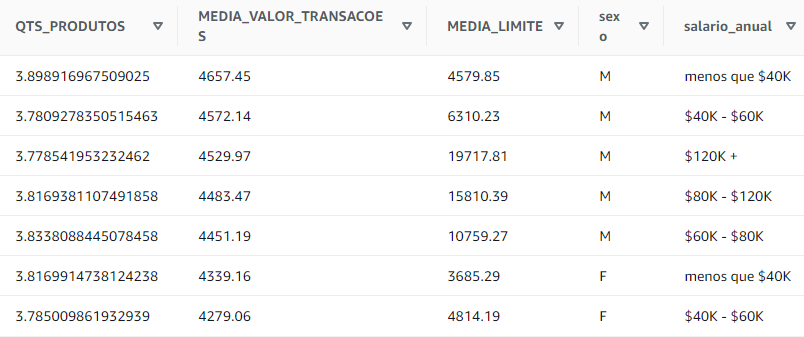

Aqui podemos ver que independente do sexo, quantidade de produtos e a media do valor de transação se mantêm similares entre as faixas salarial, enquanto a média do limite de crédito é proporcional ao aumento da faixa salarial

**Precisamos ver o valor máximo e médio de transações em 12 meses para cada tipo do cartão:**

SELECT tipo_cartao, MIN(valor_transacoes_12m) AS MIN_TRANSACOES_12M ,MAX(valor_transacoes_12m) AS MAX_TRANSACOES_12M , ROUND(AVG(valor_transacoes_12m),2) AS MEDIA_TRANSACOES_12M FROM credito
GROUP BY tipo_cartao
ORDER BY MEDIA_TRANSACOES_12M

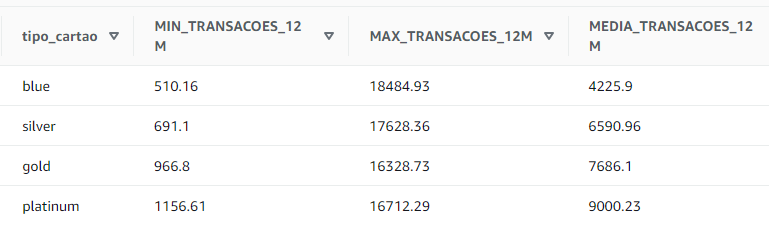

Temos muitos clientes com valor de transação alto em todos os tipo de cartão, porém quando olhamos pra média, vemos que a medida que a média do valor das transações é proporcional ao tipo de cartão.

**O salário anual impacta no limite de crédito do cliente?**

SELECT salario_anual, ROUND(AVG(limite_credito),2) AS MEDIA_LIMITE FROM credito
GROUP BY salario_anual
ORDER BY MEDIA_LIMITE DESC


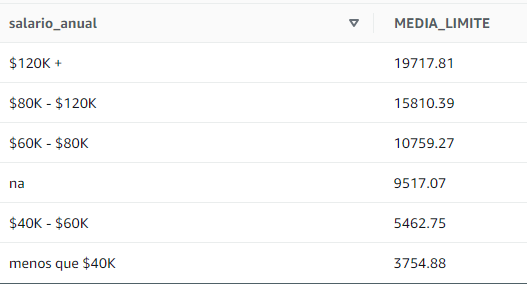

Vemos aqui que a faixa salarial está diretamente ligada a média de limite dos clientes desse banco, portanto, é ideal buscar aumentar o limite dos clientes com maior faixa salarial.

**Podemos analisar como está dividido o salário por sexo**

SELECT salario_anual, sexo, count(sexo) AS QUANTIDADE_PESSOAS FROM credito
WHERE salario_anual != 'na'
GROUP BY salario_anual, sexo
ORDER BY sexo

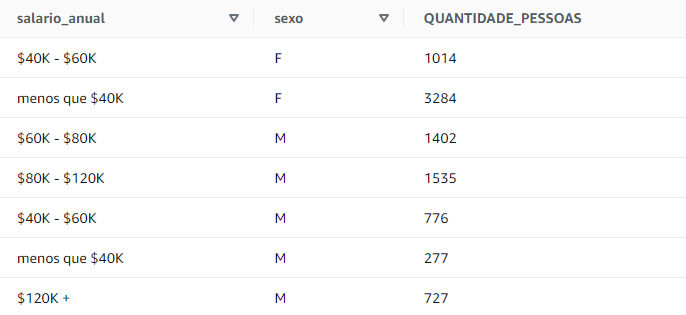

Vemos aqui que as mulheres não entram na faixa salarial acima de 40 a 60k anual.

<font size="+2">**Conclusão:**</font>

Essas foram algumas análises extraídas do conjunto de dados de crédito.

Alguns insights que podemos verificar nessa análise:

*   Boa parte dos clientes possuem uma faixa salarial até 40k
*   Vemos também que nesse banco, as mulheres possuem faixa salarial de no máximo $60k/anual, acima disso encontra-se apenas homens
*   A quantidade de clientes por sexo é bem similar
*   A média de limite dos clientes varia com o tipo do cartão, porém o valor máximo de limite entre os cartões são aproximadamente iguais, portanto seria viável estudar oferecer outros tipos de cartões para esses clientes com limite de crédito alto
*   A escolaridade parece não ser tão relevante no limite de crédito e no tipo do cartão
*   Vemos que o limite de crédito é diretamente ligado a faixa salarial dos clientes
